# Python script for a diachronical analysis of the EDH dataset
*Created by: Vojtech Kase*


Requirements:
*   Google Colab account 
*   Access to Sciencedata.dk or access alternatively to the dataset in JSON
*   Basic knowledge of Python (how to run scripts in Python notebooks)



In [0]:
### REQUIREMENTS - will install the libraries
import numpy as np
import math
import pandas as pd
import sys
import requests
from urllib.request import urlopen 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import io

# to avoid errors, we sometime use time.sleep(N) before retrying a request
import time

# the input data have typically a json structure
import json
import getpass

import datetime as dt

!pip install --ignore-installed sddk ### our own package under construction, always install to have up-to-date version
import sddk

  Using cached https://files.pythonhosted.org/packages/ad/14/48f4bd3d9d8a6ccd06fc6d325c57ac7f0a88ebc738e2fe8b3fc01d3f184e/sddk-0.1.1-py3-none-any.whl


## Establishing connection to the Sciencedata.dk: configure session and group URL

In [0]:
### configure session and groupurl
### in the case of "SDAM_root", the group owner is Vojtech with username 648597@au.dk
s, sddk_url = sddk.configure_session_and_url("SDAM_root", "648597@au.dk")   # Vojtech: Which user and password am I supposed to enter here? Vojtech's or mine? If Vojtech's than I don't know his password and will fail. If I enter mine, it does not work :(

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
personal connection established
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


## Connecting to the preprocessed and enriched JSON file / dataframe from sciencedata.dk


In [0]:
### Once the connection has been succesfuilly established, we can upload the data from sciencedata into Pandas dataframe
### Look at Pandas documention to learn how to navigate Pandas dataframe with their endless functionality: https://pandas.pydata.org/pandas-docs/version/0.23.4/index.html
EDH_df = pd.DataFrame(s.get(sddk_url + "SDAM_data/EDH/EDH_inscriptions_rich.json").json())
EDH_df.set_index("id", inplace=True) ### perhaps the best index is the "ID" # Vojtech: Why? As a user I am not sure why we need to index? - answer: once you have the data with your own index column, it makes some queries in pandas a little bit simpler, for instance, to explore particular inscription, you can easily run EDH_df.loc["HD000004"]
EDH_df.head(5) ### use ".head(5)" to inspect first 5 rows of the dataframe

,diplomatic_text,literature,trismegistos_uri,findspot_ancient,not_before,type_of_inscription,work_status,edh_geography_uri,not_after,country,province_label,transcription,material,height,width,findspot_modern,depth,commentary,uri,responsible_individual,last_update,language,modern_region,letter_size,type_of_monument,people,year_of_find,findspot,present_location,external_image_uris,religion,fotos,geography,military,social_economic_legal_history,coordinates,text_cleaned,origdate_text,objecttype
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HD000001,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",https://www.trismegistos.org/text/251193,"Cumae, bei",0071,epitaph,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0130,Italy,Latium et Campania (Regio I),D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...,"Marmor, geädert / farbig",33 cm,34 cm,"Cuma, bei",2.7 cm,(C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Campania,3.2-2 cm,tabula,"[{'cognomen': 'Optata', 'person_id': '1', 'gen...",None,None,None,None,None,None,None,None,None,"40.8471577,14.0550756",Dis Manibus Noniae Publi filiae Optatae et Cai...,71 AD – 130 AD,"[Tafel, 257]"
HD000002,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265631,Roma,0051,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,C(aius) Sextius Paris / qui vixit / annis LXX,marble: rocks - metamorphic rocks,28 cm,85 cm,Roma,None,AE 1983: Breite: 35 cm.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Lazio,4 cm,tabula,"[{'age: years': '70', 'cognomen': 'Paris', 'ge...",1937,"Via Nomentana, S. Alessandro, Kirche",None,None,None,None,None,None,None,"41.895466,12.482324",Caius Sextius Paris qui vixit annis LXX ...,51 AD – 200 AD,"[Tafel, 257]"
HD000003,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",https://www.trismegistos.org/text/220675,None,0131,honorific inscription,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0170,Spain,Baetica,[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eri...,marble: rocks - metamorphic rocks,(37) cm,(34) cm,Tomares,(12) cm,(B): [S]isenna ist falscher Kasus; folgende E...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2006-08-31,Latin,Sevilla,4.5-3 cm,statue base,"[{'nomen': 'Mummius+', 'cognomen': 'Sisenna+ R...",before 1975,None,"Sevilla, Privatbesitz",None,None,None,None,None,None,"37.37281,-6.04589",Publio Mummio Publi filio Galeria Sisennae Rut...,131 AD – 170 AD,"[Statuenbasis, 57]"
HD000004,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",https://www.trismegistos.org/text/222102,Ipolcobulcula,0151,votive inscription,checked with photo,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Spain,Baetica,[---?]AV(?)S(?)[---]L(?)L(?)A / M(arci) Porci ...,limestone: rocks - clastic sediments,(39) cm,27 cm,Carcabuey,18 cm,Material: lokaler grauer Kalkstein. (B): Styl...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Gräf,2015-03-27,Latin,Córdoba,2.5 cm,altar,"[{'cognomen': '[---]', 'status': 'slaves', 'pe...",before 1979,None,"Carcabuey, Grupo Escolar",[http://cil-old.bbaw.de/test06/bilder/datenban...,names of pagan deities,None,None,None,None,"37.4442,-4.27471",AVSLLA Marci Porci Nigri serva dominae Veneri ...,151 AD – 200 AD,"[Altar, 29]"
HD000005,[ ] L SVCCESSVS / [ ] L L IRENAEVS / [ ] C L T...,"AE 1983, 0078. (B); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265629,Roma,0001,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,[---] l(ibertus) Successus / [---] L(uci) l(ib...,None,None,None,Roma,None,(B): Z. 3: C(ai) l(ibertae) Tyches.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2010-01-04,Latin,Lazio,None,stele,"[{'st

In [0]:
len(EDH_df)

80270

In [0]:
### how many of the inscriptions have at least one date
EDH_dated = EDH_df[(EDH_df["not_before"].notnull()) | (EDH_df["not_after"].notnull())]
len(EDH_dated)

57782

In [0]:
len(EDH_dated[EDH_dated["not_before"].isnull()])

0

In [0]:
len(EDH_dated[EDH_dated["not_after"].isnull()])

3457

In [0]:
### what do these contain in the textual version of the dating?
EDH_dated[EDH_dated["not_after"].isnull()]["origdate_text"].unique()

array(['54 BC                            ',
       '213 AD                            ',
       '221 AD                            ', ...,
       '1.9.252 AD                            ',
       '1.8.209 AD                            ',
       '583 AD                            '], dtype=object)

In [0]:
def get_date_mean(row):
  """
  returns mean value of "not_before" and "not_after"
  """
  if row["not_after"]==None:
    mean_value = int(row["not_before"])
  else:
    mean_value = (int(row["not_before"]) + int(row["not_after"])) / 2
  return mean_value
def get_date_range(row):
  """
  returns range between "not_before" and "not_after"
  """
  if row["not_after"]==None:
    range_value = 0
  else:
    range_value = abs(int(row["not_before"]) - int(row["not_after"]))
  return range_value

EDH_dated["date_mean"] = EDH_dated.apply(lambda row: get_date_mean(row), axis=1)
EDH_dated["date_range"] = EDH_dated.apply(lambda row: get_date_range(row), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [0]:
EDH_dated.head()

,diplomatic_text,literature,trismegistos_uri,findspot_ancient,not_before,type_of_inscription,work_status,edh_geography_uri,not_after,country,province_label,transcription,material,height,width,findspot_modern,depth,commentary,uri,responsible_individual,last_update,language,modern_region,letter_size,type_of_monument,people,year_of_find,findspot,present_location,external_image_uris,religion,fotos,geography,military,social_economic_legal_history,coordinates,text_cleaned,origdate_text,objecttype,date_mean,date_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HD000001,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",https://www.trismegistos.org/text/251193,"Cumae, bei",0071,epitaph,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0130,Italy,Latium et Campania (Regio I),D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...,"Marmor, geädert / farbig",33 cm,34 cm,"Cuma, bei",2.7 cm,(C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Campania,3.2-2 cm,tabula,"[{'cognomen': 'Optata', 'person_id': '1', 'gen...",None,None,None,None,None,None,None,None,None,"40.8471577,14.0550756",Dis Manibus Noniae Publi filiae Optatae et Cai...,71 AD – 130 AD,"[Tafel, 257]",100.5,59
HD000002,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265631,Roma,0051,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,C(aius) Sextius Paris / qui vixit / annis LXX,marble: rocks - metamorphic rocks,28 cm,85 cm,Roma,None,AE 1983: Breite: 35 cm.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Lazio,4 cm,tabula,"[{'age: years': '70', 'cognomen': 'Paris', 'ge...",1937,"Via Nomentana, S. Alessandro, Kirche",None,None,None,None,None,None,None,"41.895466,12.482324",Caius Sextius Paris qui vixit annis LXX ...,51 AD – 200 AD,"[Tafel, 257]",125.5,149
HD000003,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",https://www.trismegistos.org/text/220675,None,0131,honorific inscription,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0170,Spain,Baetica,[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eri...,marble: rocks - metamorphic rocks,(37) cm,(34) cm,Tomares,(12) cm,(B): [S]isenna ist falscher Kasus; folgende E...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2006-08-31,Latin,Sevilla,4.5-3 cm,statue base,"[{'nomen': 'Mummius+', 'cognomen': 'Sisenna+ R...",before 1975,None,"Sevilla, Privatbesitz",None,None,None,None,None,None,"37.37281,-6.04589",Publio Mummio Publi filio Galeria Sisennae Rut...,131 AD – 170 AD,"[Statuenbasis, 57]",150.5,39
HD000004,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",https://www.trismegistos.org/text/222102,Ipolcobulcula,0151,votive inscription,checked with photo,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Spain,Baetica,[---?]AV(?)S(?)[---]L(?)L(?)A / M(arci) Porci ...,limestone: rocks - clastic sediments,(39) cm,27 cm,Carcabuey,18 cm,Material: lokaler grauer Kalkstein. (B): Styl...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Gräf,2015-03-27,Latin,Córdoba,2.5 cm,altar,"[{'cognomen': '[---]', 'status': 'slaves', 'pe...",before 1979,None,"Carcabuey, Grupo Escolar",[http://cil-old.bbaw.de/test06/bilder/datenban...,names of pagan deities,None,None,None,None,"37.4442,-4.27471",AVSLLA Marci Porci Nigri serva dominae Veneri ...,151 AD – 200 AD,"[Altar, 29]",175.5,49
HD000005,[ ] L SVCCESSVS / [ ] L L IRENAEVS / [ ] C L T...,"AE 1983, 0078. (B); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265629,Roma,0001,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,[---] l(ibertus) Successus / [---] L(uci) l(ib...,None,None,None,Roma,None,(B): Z. 3: C(ai) l(ibertae) Tyches.,https://edh-www.adw.uni-heidelberg.de/

In [0]:
### number of inscription with range lower than a century
len(EDH_dated[EDH_dated["date_range"]<100])

35933

In [0]:
### number of inscription with range lower than 50 years
len(EDH_dated[EDH_dated["date_range"]<50])

18096

# Histograms with different maximal date range and bin width

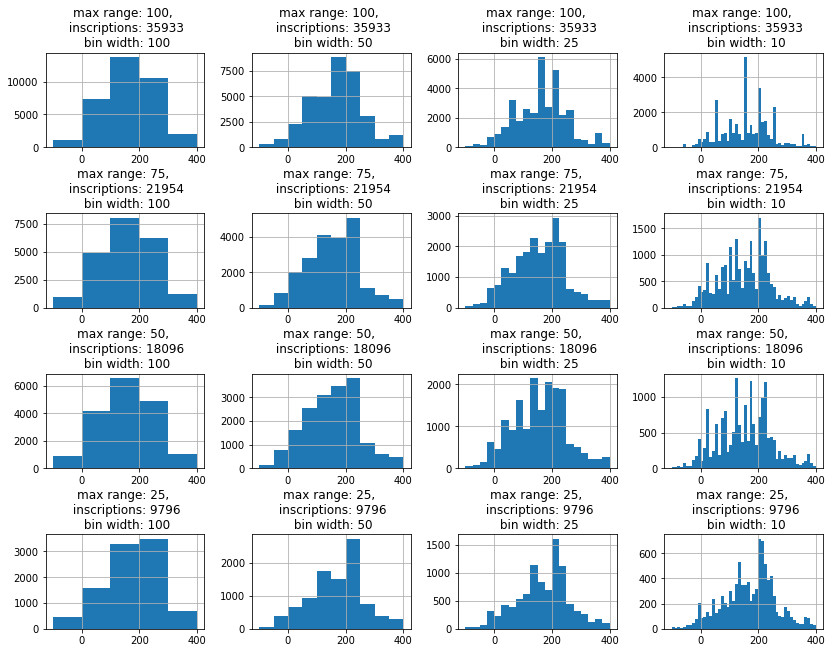

In [0]:
steps = [100,50,25,10]
max_date_ranges = [25,25,25,25,50,50,50,50,75,75,75,75,100,100,100,100][::-1] #.reverse()
bin_ranges=[]
for step in steps:
  bin_ranges.append([value for value in range(-100, 400 + step, step)])

fig, axs = plt.subplots(4, 4, figsize=(12, 8))

for ax, bin_range, max_range in zip(axs.ravel(), bin_ranges+bin_ranges+bin_ranges+bin_ranges, max_date_ranges):
    dataset = EDH_dated[EDH_dated["date_range"]<max_range]
    dataset_length = len(dataset)
    dataset["date_mean"].hist(bins=bin_range, ax=ax)
    ax.set_title("max range: " + str(max_range) + ", \n inscriptions: " + str(dataset_length) + "\n bin width: " + str(bin_range[1] - bin_range[0]))

plt.subplots_adjust(top=1, bottom=0, left=0.10, right=1, hspace=0.7,
                    wspace=0.3)


# Type of Monument

In [0]:
EDH_dated["type_of_monument"].unique()

array(['tabula', 'statue base', 'altar', 'stele', 'tessera', 'urn',
       'block', 'bar', 'mile-/leaguestone', 'stele?', None, 'herm',
       'instrumentum domesticum', 'tile', 'altar?', 'jewellery', 'cippus',
       'instrumentum militare', 'tabula?', 'paving stone?', 'sarcophagus',
       'base', 'architectural member', 'statue base?', 'cippus?', 'cupa',
       'statue', 'instrumentum sacrum', 'grave monument', 'sculpture',
       'cliff', 'block?', 'relief', 'architectural member?', 'diptych',
       'bust', 'instrumentum domesticum?',
       'honorific/grave/votive column', 'table', 'bench', 'sarcophagus?',
       'fountain', 'honorific/votive arch?', 'weapon', 'urn?', 'shield',
       'honorific/votive arch', 'instrumentum sacrum?', 'paving stone',
       'olla', 'fortification', 'relief?', 'slab', 'base?',
       'mile-/leaguestone?', 'jewellery?', 'grave monument?',
       'honorific/grave/votive column?', 'table?',
       'instrumentum militare?', 'tessera?', 'slab?', 'herm?',

In [0]:
### extract types of monument with more than 1000
mon_types = []
for mon_type in EDH_dated["type_of_monument"].unique():
  if str(mon_type)[-1] != "?":
    mon_type_df = EDH_dated[(EDH_dated["type_of_monument"]==mon_type)|(EDH_dated["type_of_monument"]==str(mon_type) + "?")]
    mon_type_len = len(mon_type_df)
    if mon_type_len > 1000:
      mon_types.append(mon_type)

In [0]:
mon_types

['tabula',
 'statue base',
 'altar',
 'stele',
 'block',
 'mile-/leaguestone',
 'instrumentum domesticum',
 'tile',
 'sarcophagus',
 'architectural member']

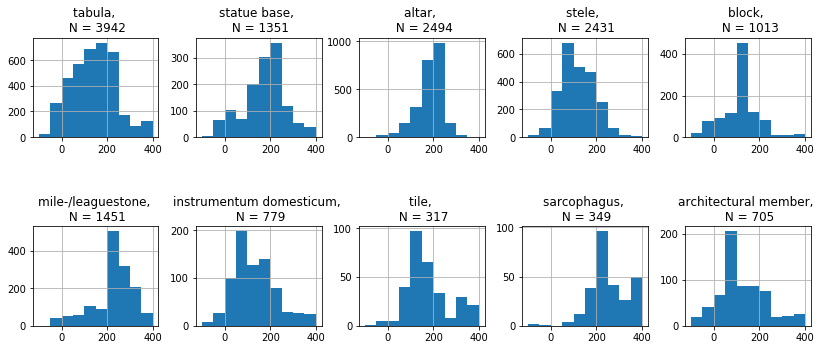

In [0]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))

for ax, mon_type in zip(axs.ravel(), mon_types):
  dataset = EDH_dated[(EDH_dated["type_of_monument"]==mon_type)|(EDH_dated["type_of_monument"]==str(mon_type) + "?")]
  dataset = dataset[dataset["date_range"]<50]
  dataset_length = len(dataset)
  dataset["date_mean"].hist(bins=bin_ranges[1], ax=ax)
  ax.set_title(mon_type + ", \n N = " + str(dataset_length))

plt.subplots_adjust(top=0.8, bottom=0, left=0.10, right=1, hspace=0.9,
                    wspace=0.3)